# Deep Fake ussing Generative Adversarial Networks
### Week-5
### Case-1

### Demonstration how to generate images of handwritten digits (like MNIST dataset) using
### a Deep Convolutional Generative Adversarial Network (DCGAN)

[source](https://arxiv.org/pdf/1511.06434.pdf)

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

##### (GANs) can be described as models which are trained simultaneously by an adversarial process.
A *generator* learns to create images that look real, while a *discriminator* learns to tell real images apart from fakes.
During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

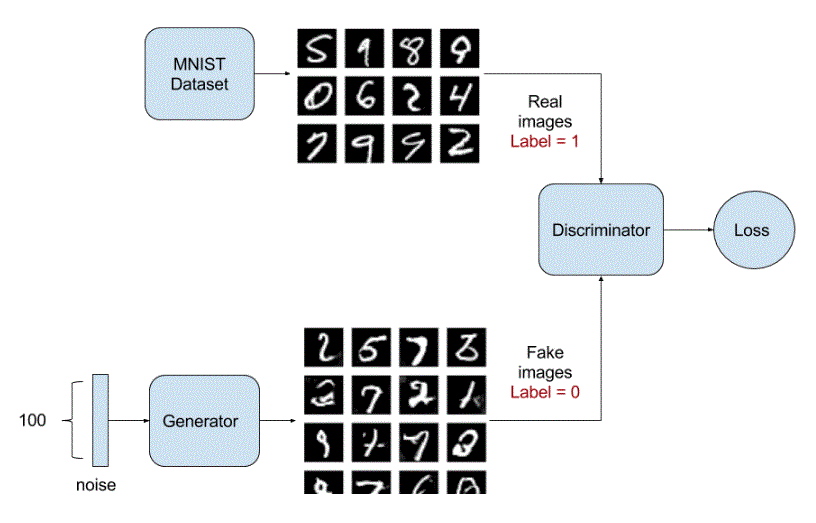

##### This notebook uses on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

### Import

image.png


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


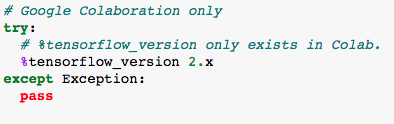

image.png

In [3]:
import tensorflow as tf


image.png

In [4]:
tf.__version__

'2.19.0'

In [1]:
# You should not do the next cell code for Google Colab !

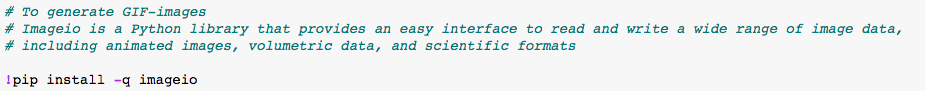

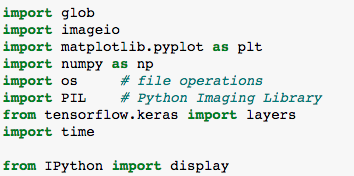


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os  # file operations
import PIL  # Python Imaging Library
from tensorflow.keras import layers
import time

from IPython import display


### MNIST Dataset
After treining the generator will generate handwritten digits resembling the MNIST data.


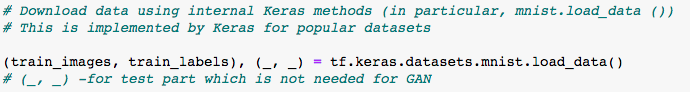

In [6]:

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


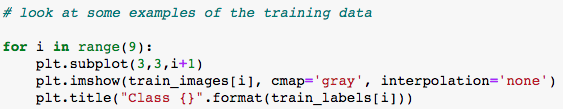

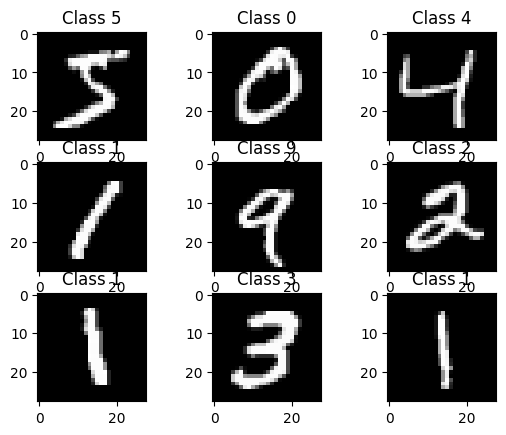

In [7]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_labels[i]))


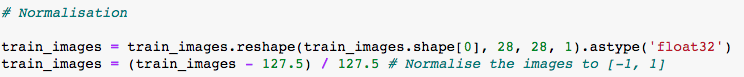

In [8]:
# Normalisation
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalise the images to [-1, 1]

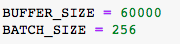

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


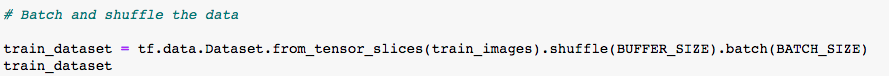

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset


<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

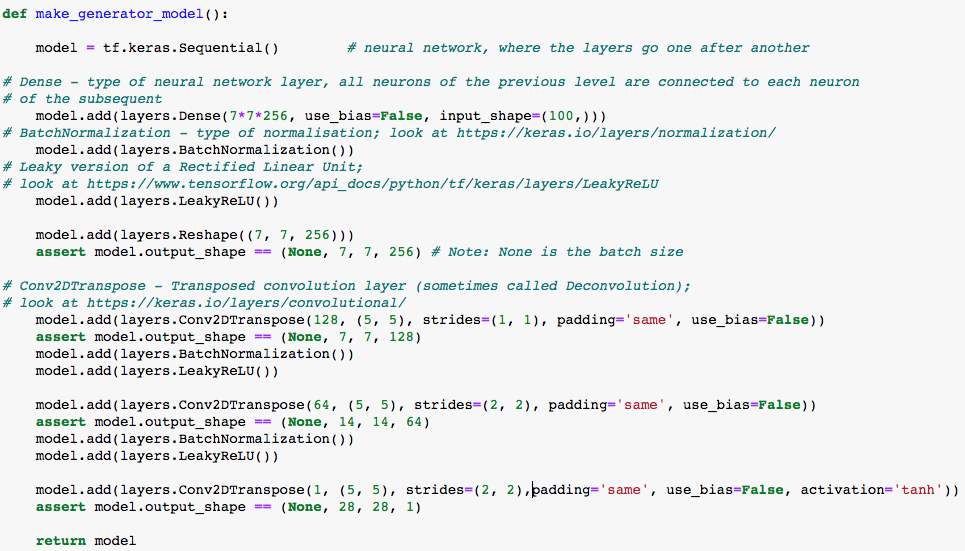


In [11]:
def make_generator_model():
    model = tf.keras.Sequential()  

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


Use the generator to create an image.


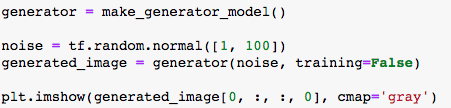



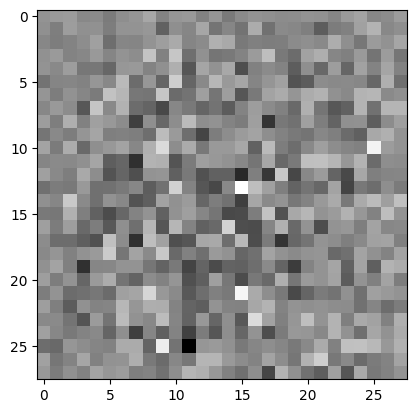

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(100,)))  # Correct way to define input
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Using it
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
# Describe why the image does not have a structure?

image.png



In [14]:
generator?

Signature:   generator(*args, **kwargs)
Type:        Sequential
String form: <Sequential name=sequential_1, built=True>
File:        c:\users\bandit\appdata\local\programs\python\python311\lib\site-packages\keras\src\models\sequential.py
Docstring:  
`Sequential` groups a linear stack of layers into a `Model`.

Examples:

```python
model = keras.Sequential()
model.add(keras.Input(shape=(16,)))
model.add(keras.layers.Dense(8))

# Note that you can also omit the initial `Input`.
# In that case the model doesn't have any weights until the first call
# to a training/evaluation method (since it isn't yet built):
model = keras.Sequential()
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(4))
# model.weights not created yet

# Whereas if you specify an `Input`, the model gets built
# continuously as you are adding layers:
model = keras.Sequential()
model.add(keras.Input(shape=(16,)))
model.add(keras.layers.Dense(8))
len(model.weights)  # Returns "2"

# When using the delayed-buil

### The Discriminator

The discriminator is a CNN-based image classifier.

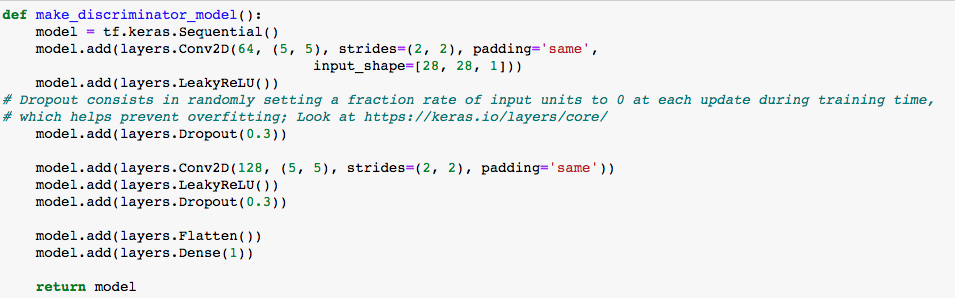

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

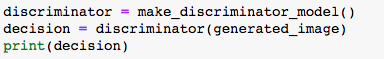

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[-0.00201352]], shape=(1, 1), dtype=float32)


image.png

In [17]:
discriminator?

Signature:   discriminator(*args, **kwargs)
Type:        Sequential
String form: <Sequential name=sequential_2, built=True>
File:        c:\users\bandit\appdata\local\programs\python\python311\lib\site-packages\keras\src\models\sequential.py
Docstring:  
`Sequential` groups a linear stack of layers into a `Model`.

Examples:

```python
model = keras.Sequential()
model.add(keras.Input(shape=(16,)))
model.add(keras.layers.Dense(8))

# Note that you can also omit the initial `Input`.
# In that case the model doesn't have any weights until the first call
# to a training/evaluation method (since it isn't yet built):
model = keras.Sequential()
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(4))
# model.weights not created yet

# Whereas if you specify an `Input`, the model gets built
# continuously as you are adding layers:
model = keras.Sequential()
model.add(keras.Input(shape=(16,)))
model.add(keras.layers.Dense(8))
len(model.weights)  # Returns "2"

# When using the delayed-

## Define the loss and optimizers

Define loss functions and optimizers for both models.


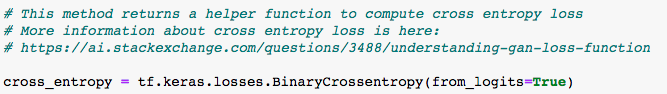

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

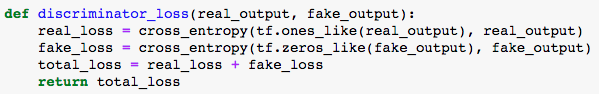

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

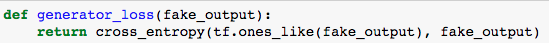

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


The discriminator and the generator optimizers are different since we will train two networks separately.

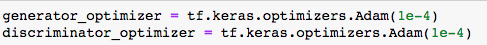

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


image.png

In [22]:
tf.keras.optimizers.Adam?


Init signature:
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    loss_scale_factor=None,
    gradient_accumulation_steps=None,
    name='adam',
    **kwargs,
)
Docstring:     
Optimizer that implements the Adam algorithm.

Adam optimization is a stochastic gradient descent method that is based on
adaptive estimation of first-order and second-order moments.

According to
[Kingma et al., 2014](http://arxiv.org/abs/1412.6980),
the method is "*computationally
efficient, has little memory requirement, invariant to diagonal rescaling of
gradients, and is well suited for problems that are large in terms of
data/parameters*".

Args:
    learning_rate: A float, a
        `keras.optimizers.schedules.LearningRateSchedule` instance, or
        a callable that 

### Save checkpoints
It is useful in case a long running training task is interrupted.


image.png

In [23]:
tf.train.Checkpoint?

Init signature: tf.train.Checkpoint(root=None, **kwargs)
Docstring:     
Manages saving/restoring trackable values to disk.

TensorFlow objects may contain trackable state, such as `tf.Variable`s,
`tf.keras.optimizers.Optimizer` implementations, `tf.data.Dataset` iterators,
`tf.keras.Layer` implementations, or  `tf.keras.Model` implementations.
These are called **trackable objects**.

A `Checkpoint` object can be constructed to save either a single or group of
trackable objects to a checkpoint file. It maintains a `save_counter` for
numbering checkpoints.

Example:

```python
model = tf.keras.Model(...)
checkpoint = tf.train.Checkpoint(model)

# Save a checkpoint to /tmp/training_checkpoints-{save_counter}. Every time
# checkpoint.save is called, the save counter is increased.
save_path = checkpoint.save('/tmp/training_checkpoints')

# Restore the checkpointed values to the `model` object.
checkpoint.restore(save_path)
```

Example 2:

```python
import tensorflow as tf
import os

check

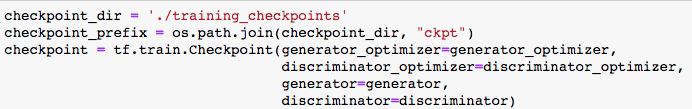

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


## Training loop



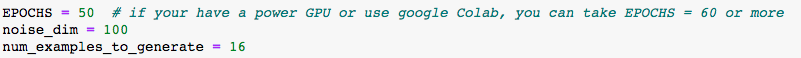


In [25]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


image.png

In [26]:
tf.random.normal?

Signature:
tf.random.normal(
    shape,
    mean=0.0,
    stddev=1.0,
    dtype=tf.float32,
    seed=None,
    name=None,
)
Docstring:
Outputs random values from a normal distribution.

Example that generates a new set of random values every time:

>>> tf.random.set_seed(5);
>>> tf.random.normal([4], 0, 1, tf.float32)
<tf.Tensor: shape=(4,), dtype=float32, numpy=..., dtype=float32)>

Example that outputs a reproducible result:

>>> tf.random.set_seed(5);
>>> tf.random.normal([2,2], 0, 1, tf.float32, seed=1)
<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.3768897 , -0.01258316],
      [-0.169515   ,  1.0824056 ]], dtype=float32)>

In this case, we are setting both the global and operation-level seed to
ensure this result is reproducible.  See `tf.random.set_seed` for more
information.

Args:
  shape: A 1-D integer Tensor or Python array. The shape of the output tensor.
  mean: A Tensor or Python value of type `dtype`, broadcastable with `stddev`.
    The mean of the normal di

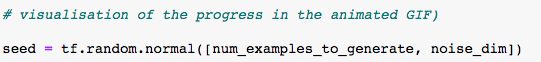

In [27]:

seed = tf.random.normal([num_examples_to_generate, noise_dim])


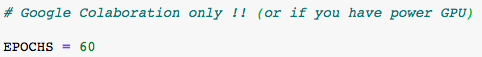

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

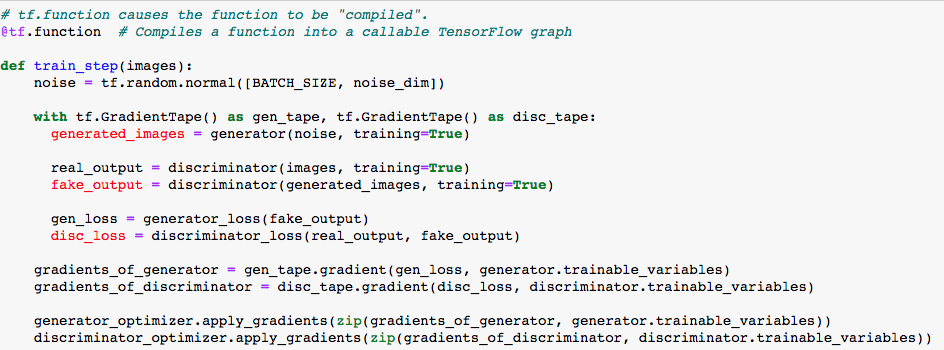

In [28]:
# tf.function causes the function to be "compiled".
@tf.function  # Compiles a function into a callable TensorFlow graph
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


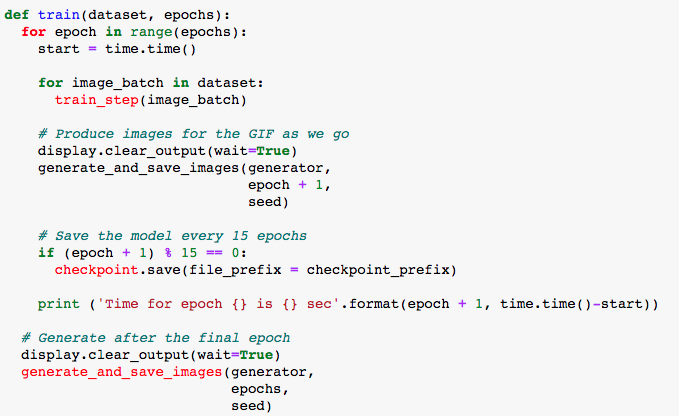

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


**Generate and save images**



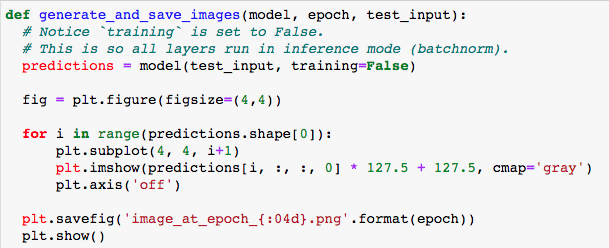

In [32]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


## Train the model
train() - training the generator and discriminator simultaneously.
It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

In [ ]:
# Save your Jupyter Notebook before start the next cell

image.png

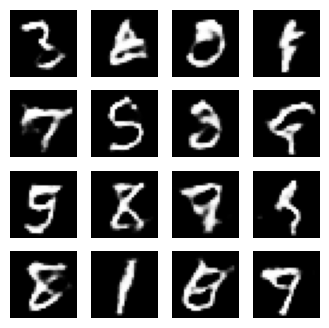

In [34]:
train(train_dataset, EPOCHS)


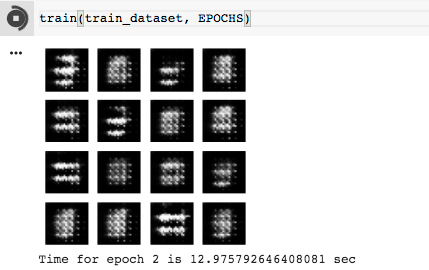

image.png

Restore the latest checkpoint.

image.png

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


### Show the result as a GIF-file


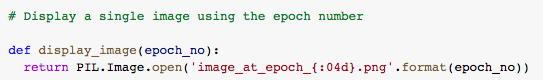

In [43]:
# Display a single image using the epoch number
epoch_no = 27
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


image.png

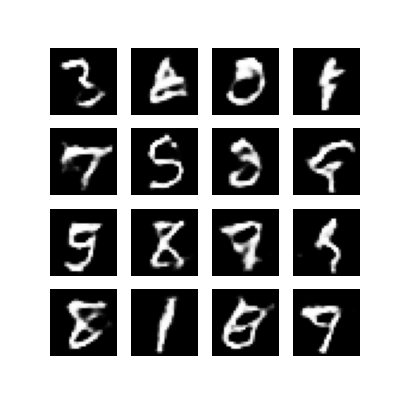

In [44]:
display_image(EPOCHS)

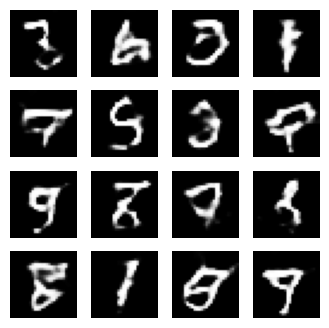

Epoch 50
Time spent on this epoch: 1.10 seconds


In [45]:
epoch_no = EPOCHS
start = time.time()

# Generate and display final image grid
generate_and_save_images(generator, epoch_no, seed)

elapsed = time.time() - start
print(f"Epoch {epoch_no}")
print(f"Time spent on this epoch: {elapsed:.2f} seconds")


Use `imageio` to create an animated gif using the images saved during training.

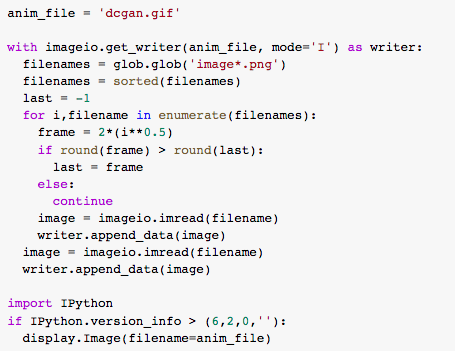

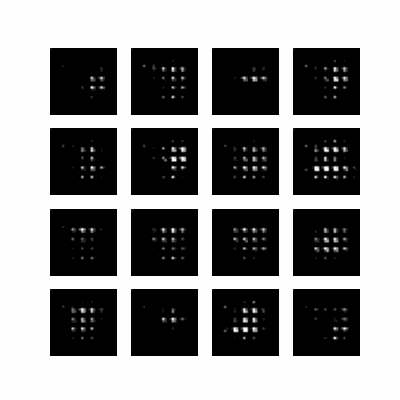

In [38]:
anim_file = 'dcgan.gif'

# Use imageio.v2 to maintain compatibility
import imageio.v2 as imageio
import glob

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i * 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython
from IPython import display

if IPython.version_info > (6, 2, 0, ''):
    display.display(display.Image(filename=anim_file))


If you're working in Colab you can download the animation with the code below:

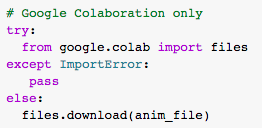

# Lab Logbook requirement:


## You should copy a screenshot of the GAN training result at a specific epoch to your logbook. The screenshot must contain the digital images, the epoch number and the time spent training for this epoch.
### Determine this epoch number using the following method:
### Take the last two digits from your SID. If this number is less than or equal to 50, it is the required epoch number. If this number is 50 or less, it becomes the required epoch number. If it exceeds 50, divide it by 50 and round up if necessary. For example, if your SID is 2187467, and the last two digits are 67, which is greater than 50. Divide by 50, resulting in 33.5. Round up to 34, and this becomes your epoch number.